In [1]:
import os
import pandas as pd
from IPython.display import display

# list to summon all files
sampled_dfs = []

# Find the folder
base_dir = os.getcwd()

# Supervise all files
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file == "T_ONTIME_REPORTING.csv":  # Matcher filnavne præcist
            csv_path = os.path.join(root, file)
            try:
                # Robust loading, remove useless data
                try:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="utf-8", on_bad_lines="skip")
                except Exception:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="latin1", on_bad_lines="skip")


                # sample max 300 rows, per. file
                sample_size = min(300, len(df))
                sample = df.sample(sample_size, random_state=42)
                sampled_dfs.append(sample)

                print(f"✅ added correctly: {csv_path} ({sample_size} rows)")

            except Exception as e:
                print(f" incorrect loading {csv_path}: {e}")

# Combine files to a shared dataframe
if sampled_dfs:
    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"\n📊 final dataset {len(df):,} rows from {len(sampled_dfs)} files.")
    display(df.head())
else:
    print("No file was found")

✅ added correctly: /Users/robinribelrifai/Desktop/Data months/April/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/december/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/february/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/June/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/July/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/August/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/May/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/Oktober/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/November/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/January/T_ON

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,...,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_TIME_BLK,FLIGHTS,DISTANCE
0,2024,4,12,18,3,12/18/2024 12:00:00 AM,1293.0,12892,LAX,California,...,"Seattle, WA",Washington,600,553.0,858.0,846.0,0.0,0800-0859,1.0,954.0
1,2024,4,12,13,5,12/13/2024 12:00:00 AM,3764.0,13930,ORD,Illinois,...,"Indianapolis, IN",Indiana,1338,1336.0,1537.0,1531.0,0.0,1500-1559,1.0,177.0
2,2024,4,12,31,2,12/31/2024 12:00:00 AM,1788.0,14747,SEA,Washington,...,"Houston, TX",Texas,704,701.0,1327.0,1315.0,0.0,1300-1359,1.0,1874.0
3,2024,4,12,22,7,12/22/2024 12:00:00 AM,5487.0,11057,CLT,North Carolina,...,"Jacksonville/Camp Lejeune, NC",North Carolina,2047,2139.0,2156.0,2230.0,1.0,2100-2159,1.0,191.0
4,2024,4,12,13,5,12/13/2024 12:00:00 AM,5374.0,11150,CSG,Georgia,...,"Atlanta, GA",Georgia,1742,1734.0,1845.0,1814.0,0.0,1800-1859,1.0,83.0


In [2]:
# --- Prepare data for Logistic Classification Model (Leakage-Free Version) ---
# This cell creates the delay target variable and time-based predictors that can be known before departure.

import numpy as np
import pandas as pd

# --- Convert HHMM → minutes since midnight ---
# This function transforms scheduled or actual departure times into total minutes since midnight.
def hhmm_to_minutes(x):
    try:
        x = int(float(str(x).strip()))
        h, m = x // 100, x % 100
        return min(h * 60 + m, 1439)  # cap at 23:59
    except:
        return np.nan

# --- Create minute-based columns for actual and scheduled departure times ---
if "DEP_TIME" in df.columns:
    df["DEP_TIME_MIN"] = df["DEP_TIME"].apply(hhmm_to_minutes)

if "CRS_DEP_TIME" in df.columns:
    df["CRS_DEP_TIME_MIN"] = df["CRS_DEP_TIME"].apply(hhmm_to_minutes)

# --- Calculate delay in minutes (only for creating the target variable) ---
# Note: This column will NOT be used as an input feature to prevent data leakage.
if {"DEP_TIME_MIN", "CRS_DEP_TIME_MIN"}.issubset(df.columns):
    df["DEP_DELAY_MIN"] = df["DEP_TIME_MIN"] - df["CRS_DEP_TIME_MIN"]

print("\n'DEP_DELAY_MIN' successfully calculated.")
display(df[["DEP_TIME_MIN", "CRS_DEP_TIME_MIN", "DEP_DELAY_MIN"]].head())

# --- Create the binary target variable for logistic classification ---
# 1 = delayed more than 15 minutes, 0 = on time
df["DELAYED"] = (df["DEP_DELAY_MIN"] > 15).astype(int)

print("\nTarget variable 'DELAYED' created (1 = delayed, 0 = on time).")
display(df[["DEP_DELAY_MIN", "DELAYED"]].head())

# --- Create cyclic time features for departure time ---
# These encode the time of day in a circular format to capture daily patterns
# (e.g., 23:59 and 00:01 are close in time, not far apart).
if "CRS_DEP_TIME_MIN" in df.columns:
    df["DEP_TIME_sin"] = np.sin(2 * np.pi * df["CRS_DEP_TIME_MIN"] / 1440)
    df["DEP_TIME_cos"] = np.cos(2 * np.pi * df["CRS_DEP_TIME_MIN"] / 1440)
    print("\nCyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.")
    display(df[["CRS_DEP_TIME_MIN", "DEP_TIME_sin", "DEP_TIME_cos"]].head())




'DEP_DELAY_MIN' successfully calculated.


,DEP_TIME_MIN,CRS_DEP_TIME_MIN,DEP_DELAY_MIN
0,353.0,360,-7.0
1,816.0,818,-2.0
2,421.0,424,-3.0
3,1299.0,1247,52.0
4,1054.0,1062,-8.0



Target variable 'DELAYED' created (1 = delayed, 0 = on time).


,DEP_DELAY_MIN,DELAYED
0,-7.0,0
1,-2.0,0
2,-3.0,0
3,52.0,1
4,-8.0,0



Cyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.


,CRS_DEP_TIME_MIN,DEP_TIME_sin,DEP_TIME_cos
0,360,1.000000,6.123234e-17
1,818,-0.414693,-9.099613e-01
2,424,0.961262,-2.756374e-01
3,1247,-0.746057,6.658817e-01
4,1062,-0.996917,-7.845910e-02


In [6]:
# --- Convert DEP_TIME_MIN into 15-minute bins (categorical) ---
df["DEP_TIME_BIN"] = pd.cut(
    df["DEP_TIME_MIN"],
    bins=range(0, 1441, 15),
    labels=[f"{h:02d}:{m:02d}" for h in range(24) for m in range(0, 60, 15)]
)

print("\n🕒 Sample of 15-minute bins:")
display(df[["DEP_TIME_MIN", "DEP_TIME_BIN"]].head())

# --- Select model features ---
selected_features = ["MONTH",         
    "DAY_OF_WEEK",  
    "DAY_OF_MONTH",
    "DISTANCE",       
    "ORIGIN",        
    "DEST", 
    "DEP_TIME_sin",   
    "DEP_TIME_cos",   
    "OP_CARRIER_FL_NUM"]

# --- Keep only relevant rows (drop NaN) ---
df_model = df[selected_features + ["DELAYED"]].dropna()

X = df_model[selected_features]
y = df_model["DELAYED"]

print(f"\n📊 Final dataset ready for modeling: {len(X)} rows, {len(selected_features)} features.")
display(X.head())



🕒 Sample of 15-minute bins:


,DEP_TIME_MIN,DEP_TIME_BIN
0,353.0,05:45
1,816.0,13:30
2,421.0,07:00
3,1299.0,21:30
4,1054.0,17:30



📊 Final dataset ready for modeling: 3600 rows, 9 features.


,MONTH,DAY_OF_WEEK,DAY_OF_MONTH,DISTANCE,ORIGIN,DEST,DEP_TIME_sin,DEP_TIME_cos,OP_CARRIER_FL_NUM
0,12,3,18,954.0,LAX,SEA,1.000000,6.123234e-17,1293.0
1,12,5,13,177.0,ORD,IND,-0.414693,-9.099613e-01,3764.0
2,12,2,31,1874.0,SEA,IAH,0.961262,-2.756374e-01,1788.0
3,12,7,22,191.0,CLT,OAJ,-0.746057,6.658817e-01,5487.0
4,12,5,13,83.0,CSG,ATL,-0.996917,-7.845910e-02,5374.0


✅ Numeric features: ['MONTH', 'DAY_OF_WEEK', 'DAY_OF_MONTH', 'DISTANCE', 'DEP_TIME_sin', 'DEP_TIME_cos', 'OP_CARRIER_FL_NUM']
✅ Categorical features: ['ORIGIN', 'DEST']

📊 Dataset ready: 3600 rows


,MONTH,DAY_OF_WEEK,DAY_OF_MONTH,DISTANCE,DEP_TIME_sin,DEP_TIME_cos,OP_CARRIER_FL_NUM,ORIGIN,DEST
0,12,3,18,954.0,1.000000,6.123234e-17,1293.0,LAX,SEA
1,12,5,13,177.0,-0.414693,-9.099613e-01,3764.0,ORD,IND
2,12,2,31,1874.0,0.961262,-2.756374e-01,1788.0,SEA,IAH
3,12,7,22,191.0,-0.746057,6.658817e-01,5487.0,CLT,OAJ
4,12,5,13,83.0,-0.996917,-7.845910e-02,5374.0,CSG,ATL


Training set: 2880 | Test set: 720

✅ Logistic Regression model trained successfully

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.65      0.74       580
           1       0.27      0.54      0.36       140

    accuracy                           0.63       720
   macro avg       0.56      0.60      0.55       720
weighted avg       0.74      0.63      0.67       720

ROC-AUC Score: 0.625


<Figure size 500x400 with 0 Axes>

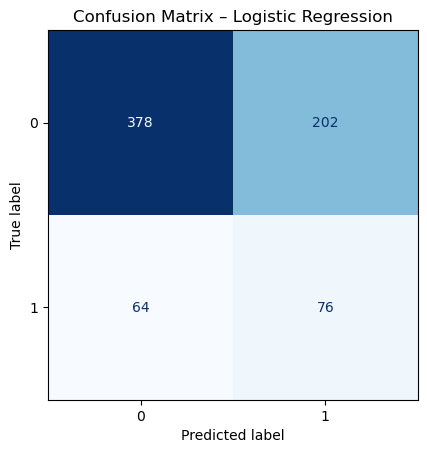

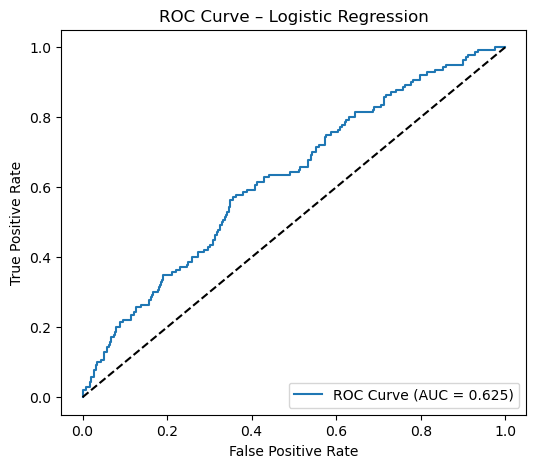

In [11]:
# =========================================================
# ✅ FEATURE PREPARATION & LOGISTIC REGRESSION (CLEAN)
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)

# ---------------------------------------------------------
# 1. DEFINE FEATURES (CORRECT SPLIT)
# ---------------------------------------------------------

feature_cols_numeric = [
    "MONTH",
    "DAY_OF_WEEK",
    "DAY_OF_MONTH",
    "DISTANCE",
    "DEP_TIME_sin",
    "DEP_TIME_cos",
    "OP_CARRIER_FL_NUM"   # numeric flight number
]

feature_cols_categorical = [
    "ORIGIN",
    "DEST"
]

# ---------------------------------------------------------
# 2. KEEP ONLY COLUMNS THAT EXIST
# ---------------------------------------------------------

feature_cols_numeric = [c for c in feature_cols_numeric if c in df.columns]
feature_cols_categorical = [c for c in feature_cols_categorical if c in df.columns]

print("✅ Numeric features:", feature_cols_numeric)
print("✅ Categorical features:", feature_cols_categorical)

# ---------------------------------------------------------
# 3. CLEAN DATA (NO MISSING VALUES)
# ---------------------------------------------------------

df = df.dropna(
    subset=feature_cols_numeric + feature_cols_categorical + ["DELAYED"]
)

# Define X and y
X = df[feature_cols_numeric + feature_cols_categorical]
y = df["DELAYED"]

print(f"\n📊 Dataset ready: {len(X)} rows")
display(X.head())

# ---------------------------------------------------------
# 4. TRAIN / TEST SPLIT
# ---------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {len(X_train)} | Test set: {len(X_test)}")

# ---------------------------------------------------------
# 5. PREPROCESSING PIPELINE
# ---------------------------------------------------------

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), feature_cols_numeric),
        ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_categorical)
    ]
)

# ---------------------------------------------------------
# 6. LOGISTIC REGRESSION MODEL
# ---------------------------------------------------------

log_reg = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    class_weight="balanced"
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", log_reg)
    ]
)

# ---------------------------------------------------------
# 7. TRAIN MODEL
# ---------------------------------------------------------

pipeline.fit(X_train, y_train)
print("\n✅ Logistic Regression model trained successfully")

# ---------------------------------------------------------
# 8. EVALUATION
# ---------------------------------------------------------

y_pred = pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.3f}")

# Confusion Matrix
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(
    cmap="Blues",
    colorbar=False
)
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend(loc="lower right")
plt.show()



In [12]:
# Add holiday attribute
df['Holiday?'] = (
    ((df['MONTH'] == 12) & (df['DAY_OF_MONTH'] >= 20)) |  # Dec 20–31
    ((df['MONTH'] == 1) & (df['DAY_OF_MONTH'] <= 5))   |  # Jan 1–5
    (df['MONTH'].isin([7, 8]))                           # July & August
)
# Filtrér så vi kun viser data fra holiday-perioden
df = df[df["Holiday?"] == True]
df

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,...,FLIGHTS,DISTANCE,DEP_TIME_MIN,CRS_DEP_TIME_MIN,DEP_DELAY_MIN,DELAYED,DEP_TIME_sin,DEP_TIME_cos,DEP_TIME_BIN,Holiday?
2,2024,4,12,31,2,12/31/2024 12:00:00 AM,1788.0,14747,SEA,Washington,...,1.0,1874.0,421.0,424,-3.0,0,0.961262,-0.275637,07:00,True
3,2024,4,12,22,7,12/22/2024 12:00:00 AM,5487.0,11057,CLT,North Carolina,...,1.0,191.0,1299.0,1247,52.0,1,-0.746057,0.665882,21:30,True
5,2024,4,12,25,3,12/25/2024 12:00:00 AM,3176.0,11298,DFW,Texas,...,1.0,986.0,576.0,585,-9.0,0,0.555570,-0.831470,09:30,True
6,2024,4,12,28,6,12/28/2024 12:00:00 AM,4284.0,10423,AUS,Texas,...,1.0,189.0,1182.0,1130,52.0,1,-0.976296,0.216440,19:30,True
10,2024,4,12,25,3,12/25/2024 12:00:00 AM,1539.0,14908,SNA,California,...,1.0,2099.0,518.0,520,-2.0,0,0.766044,-0.642788,08:30,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,2024,3,8,15,4,8/15/2024 12:00:00 AM,714.0,14747,SEA,Washington,...,1.0,1050.0,756.0,764,-8.0,0,-0.190809,-0.981627,12:30,True
3296,2024,3,8,14,3,8/14/2024 12:00:00 AM,6208.0,10372,ASE,Colorado,...,1.0,701.0,856.0,868,-12.0,0,-0.601815,-0.798636,14:15,True
3297,2024,3,8,21,3,8/21/2024 12:00:00 AM,5458.0,10980,CHA,Tennessee,...,1.0,241.0,646.0,658,-12.0,0,0.267238,-0.963630,10:45,True
3298,2024,3,8,29,4,8/29/2024 12:00:00 AM,2337.0,14100,PHL,Pennsylvania,...,1.0,453.0,561.0,574,-13.0,0,0.594823,-0.803857,09:15,True


In [13]:
# --- Create sine and cosine features for departure time ---
# Converts the time of day (in minutes) into circular values between -1 and 1
# This allows the model to understand the cyclical nature of time (e.g. 23:59 and 00:01 are close).

import numpy as np

if "DEP_TIME_MIN" in df.columns:
    df["DEP_TIME_sin"] = np.sin(2 * np.pi * df["DEP_TIME_MIN"].fillna(0) / 1440)
    df["DEP_TIME_cos"] = np.cos(2 * np.pi * df["DEP_TIME_MIN"].fillna(0) / 1440)
    print("Cyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.")
else:
    print("Error: Column 'DEP_TIME_MIN' not found. Make sure it is created before running this cell.")

display(df[["DEP_TIME_MIN", "DEP_TIME_sin", "DEP_TIME_cos"]].head())


Cyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.


,DEP_TIME_MIN,DEP_TIME_sin,DEP_TIME_cos
2,421.0,0.964787,-0.263031
3,1299.0,-0.577145,0.816642
5,576.0,0.587785,-0.809017
6,1182.0,-0.902585,0.430511
10,518.0,0.771625,-0.636078


Holiday dataset created with 466 rows out of 466 total flights.
Logistic Regression model for holiday flights trained successfully.

Classification Report (Holiday flights):
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        71
           1       0.31      0.35      0.33        23

    accuracy                           0.65        94
   macro avg       0.54      0.55      0.54        94
weighted avg       0.66      0.65      0.66        94

ROC-AUC Score (Holiday flights): 0.556


<Figure size 500x400 with 0 Axes>

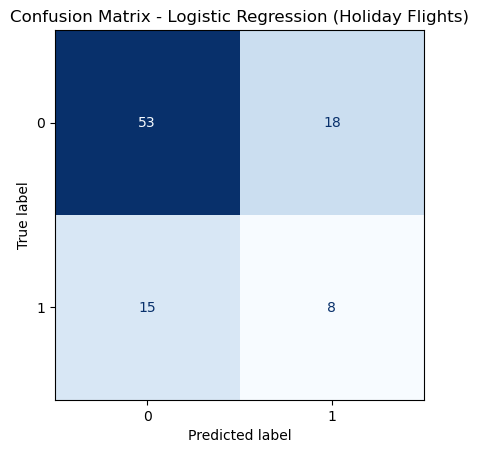

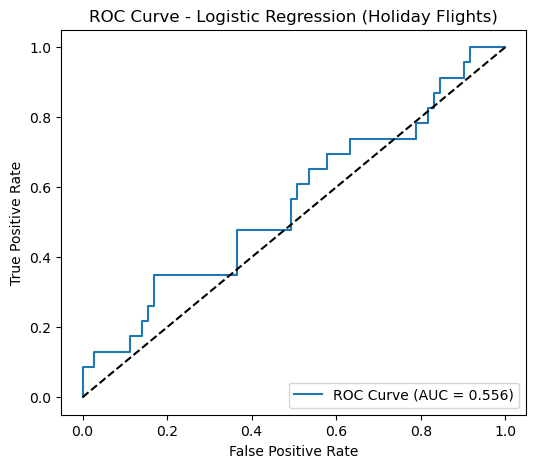

In [14]:
# --- Logistic Regression Model Focused on Holiday Flights ---
# This model isolates data from specific holiday periods (e.g., Christmas, New Year, July, and August)
# to examine whether flight delays occur more frequently during these high-traffic times.

# Step 1: Define holiday periods
df["Holiday?"] = (
    ((df["MONTH"] == 12) & (df["DAY_OF_MONTH"] >= 20)) |  # December 20–31
    ((df["MONTH"] == 1) & (df["DAY_OF_MONTH"] <= 5))   |  # January 1–5
    (df["MONTH"].isin([7, 8]))                            # July and August
)

# Step 2: Keep only flights that took place during holiday periods
df_holiday = df[df["Holiday?"] == True].copy()
print(f"Holiday dataset created with {len(df_holiday)} rows out of {len(df)} total flights.")

# Step 3: Select the features and target variable for modeling
# We include time, distance, and location-related variables that are available before the flight departs.
feature_cols_numeric = [
    "MONTH", "DAY_OF_WEEK", "DAY_OF_MONTH",
    "DISTANCE", "DEP_TIME_sin", "DEP_TIME_cos"
]
feature_cols_categorical = ["ORIGIN", "DEST"]
target_col = "DELAYED"

# Step 4: Remove rows with missing values to ensure the model trains correctly
df_holiday = df_holiday.dropna(subset=feature_cols_numeric + feature_cols_categorical + [target_col])

# Step 5: Define X (independent variables) and y (dependent variable)
X_holiday = df_holiday[feature_cols_numeric + feature_cols_categorical]
y_holiday = df_holiday[target_col]

# Step 6: Split the data into training and test sets
# The training set is used to train the model, while the test set evaluates its performance.
from sklearn.model_selection import train_test_split
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_holiday, y_holiday, test_size=0.2, random_state=42, stratify=y_holiday
)

# Step 7: Preprocessing and model setup
# - Numeric variables are standardized (scaled) using StandardScaler.
# - Categorical variables are one-hot encoded so the model can interpret text labels.
# - The model uses class_weight="balanced" to compensate for class imbalance.
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocessor_h = ColumnTransformer(transformers=[
    ("num", StandardScaler(), feature_cols_numeric),
    ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_categorical)
])

log_reg_h = LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced")

pipeline_h = Pipeline(steps=[
    ("preprocessor", preprocessor_h),
    ("classifier", log_reg_h)
])

# Step 8: Train the model on holiday data
pipeline_h.fit(X_train_h, y_train_h)
print("Logistic Regression model for holiday flights trained successfully.")

# Step 9: Evaluate model performance
# We evaluate the model using metrics such as accuracy, recall, precision, and ROC-AUC.
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Generate predictions for the test set
y_pred_h = pipeline_h.predict(X_test_h)
y_prob_h = pipeline_h.predict_proba(X_test_h)[:, 1]

# Step 10: Display classification metrics
print("\nClassification Report (Holiday flights):")
print(classification_report(y_test_h, y_pred_h))

# Compute and print the ROC-AUC score
roc_auc_h = roc_auc_score(y_test_h, y_prob_h)
print(f"ROC-AUC Score (Holiday flights): {roc_auc_h:.3f}")

# Step 11: Plot the confusion matrix
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay(confusion_matrix(y_test_h, y_pred_h)).plot(cmap="Blues", colorbar=False)
plt.title("Confusion Matrix - Logistic Regression (Holiday Flights)")
plt.show()

# Step 12: Plot the ROC curve
fpr_h, tpr_h, _ = roc_curve(y_test_h, y_prob_h)
plt.figure(figsize=(6,5))
plt.plot(fpr_h, tpr_h, label=f"ROC Curve (AUC = {roc_auc_h:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Holiday Flights)")
plt.legend(loc="lower right")
plt.show()
